In [1]:
# Stage 1

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
monthly = pd.read_csv("monthly_features.csv", parse_dates=["Date"], index_col="Date").sort_index()

In [4]:
X = monthly.drop(columns=["Label_next_month"])
y = monthly["Label_next_month"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=False
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (97, 24)
Testing set size: (18, 24)


In [5]:
X_train.head()

,Month_start,Month_end,High,Low,Year,Return_prev_month,Volatility_prev_month,Range_prev_month,MA5d_minus_MA20d,MA3m,...,December,February,January,July,June,March,May,November,October,September
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-31,2108.29,2107.39,2130.82,2080.15,2015,-0.000427,0.006810,50.67,4.4405,2086.930000,...,False,False,False,False,False,False,True,False,False,False
2015-06-30,2111.73,2063.11,2124.20,2057.64,2015,-0.023024,0.007012,66.56,-11.5195,2085.336667,...,False,False,False,False,True,False,False,False,False,False
2015-07-31,2077.42,2103.84,2128.28,2046.68,2015,0.012718,0.007372,81.60,0.5380,2091.446667,...,False,False,False,True,False,False,False,False,False,False
2015-08-31,2098.04,1972.18,2104.18,1867.61,2015,-0.059989,0.016831,236.57,-85.5915,2046.376667,...,False,False,False,False,False,False,False,False,False,False
2015-09-30,1913.85,1920.03,1995.31,1881.77,2015,0.003229,0.014185,113.54,-36.0360,1998.683333,...,False,False,False,False,False,False,False,False,False,True


In [6]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [7]:
y_pred_lr = lin_reg.predict(X_test)

In [8]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae  = mean_absolute_error(y_test, y_pred_lr)
r2   = r2_score(y_test, y_pred_lr)

print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)

RMSE: 0.06686808052862642
MAE : 0.058162564333033843
R²  : -2.8959587706841092


In [42]:
# Stage 2

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
df = pd.read_csv("monthly_features.csv", parse_dates=["Date"], index_col="Date").sort_index()

In [12]:
df.head()

,Month_start,Month_end,High,Low,Year,Return_prev_month,Volatility_prev_month,Range_prev_month,MA5d_minus_MA20d,MA3m,...,February,January,July,June,March,May,November,October,September,Label_next_month
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-31,2108.29,2107.39,2130.82,2080.15,2015,-0.000427,0.006810,50.67,4.4405,2086.930000,...,False,False,False,False,False,True,False,False,False,-0.023024
2015-06-30,2111.73,2063.11,2124.20,2057.64,2015,-0.023024,0.007012,66.56,-11.5195,2085.336667,...,False,False,False,True,False,False,False,False,False,0.012718
2015-07-31,2077.42,2103.84,2128.28,2046.68,2015,0.012718,0.007372,81.60,0.5380,2091.446667,...,False,False,True,False,False,False,False,False,False,-0.059989
2015-08-31,2098.04,1972.18,2104.18,1867.61,2015,-0.059989,0.016831,236.57,-85.5915,2046.376667,...,False,False,False,False,False,False,False,False,False,0.003229
2015-09-30,1913.85,1920.03,1995.31,1881.77,2015,0.003229,0.014185,113.54,-36.0360,1998.683333,...,False,False,False,False,False,False,False,False,True,0.080850


In [13]:
feature_cols = [c for c in df.columns if c != "Label_next_month"]

In [14]:
feat = df[feature_cols].values.astype(np.float32)             
labels = df["Label_next_month"].values.astype(np.float32)   

In [15]:
lookback = 12
X_list, y_list = [], []
for t in range(lookback - 1, len(df)):
    X_list.append(feat[t - lookback + 1 : t + 1, :])  # (T,F)
    y_list.append([labels[t]])                        # (1,)
X_all = np.stack(X_list).astype(np.float32)           # (N, T, F)
y_all = np.stack(y_list).astype(np.float32)           # (N, 1)
N, T, F = X_all.shape
print(f"N={N}, T={T}, F={F}")

N=104, T=12, F=24


In [16]:
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

X_train = X_all[:n_train]
y_train = y_all[:n_train]
X_val   = X_all[n_train:n_train+n_val]
y_val   = y_all[n_train:n_train+n_val]
X_test  = X_all[n_train+n_val:]
y_test  = y_all[n_train+n_val:]

In [17]:
scaler = StandardScaler()
Xtr2 = X_train.reshape(-1, F)
scaler.fit(Xtr2)

def scale_3d(X3):
    X2 = X3.reshape(-1, F)
    X2 = scaler.transform(X2)
    return X2.reshape(X3.shape)

X_train = scale_3d(X_train)
X_val   = scale_3d(X_val)
X_test  = scale_3d(X_test)

In [18]:
torch.manual_seed(0)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val,   dtype=torch.float32)
y_val   = torch.tensor(y_val,   dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)


In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)    
        out = out[:, -1, :]       
        out = self.fc(out)       
        return out

In [20]:
hidden_size = 32
model = LSTMModel(input_size=F, hidden_size=hidden_size, num_layers=1, dropout=0.0) 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def predict(X):
    return model(X)

In [22]:
epochs = 200
for ep in range(1, epochs + 1):
    model.train()
    pred_tr = predict(X_train)
    loss_tr = criterion(pred_tr, y_train)

    optimizer.zero_grad()
    loss_tr.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred_val = predict(X_val)
        loss_val = criterion(pred_val, y_val)

    if ep % 10 == 0 or ep == 1 or ep == epochs:
        print(f"Epoch {ep:03d} | train MSE={loss_tr.item():.6f} | val MSE={loss_val.item():.6f}")


Epoch 001 | train MSE=0.009723 | val MSE=0.012644
Epoch 010 | train MSE=0.003079 | val MSE=0.004753
Epoch 020 | train MSE=0.001739 | val MSE=0.004255
Epoch 030 | train MSE=0.001157 | val MSE=0.004067
Epoch 040 | train MSE=0.000867 | val MSE=0.003540
Epoch 050 | train MSE=0.000668 | val MSE=0.003556
Epoch 060 | train MSE=0.000527 | val MSE=0.003696
Epoch 070 | train MSE=0.000429 | val MSE=0.003649
Epoch 080 | train MSE=0.000355 | val MSE=0.003341
Epoch 090 | train MSE=0.000297 | val MSE=0.003301
Epoch 100 | train MSE=0.000249 | val MSE=0.003157
Epoch 110 | train MSE=0.000209 | val MSE=0.003089
Epoch 120 | train MSE=0.000177 | val MSE=0.003032
Epoch 130 | train MSE=0.000149 | val MSE=0.002991
Epoch 140 | train MSE=0.000126 | val MSE=0.002988
Epoch 150 | train MSE=0.000107 | val MSE=0.003007
Epoch 160 | train MSE=0.000092 | val MSE=0.003047
Epoch 170 | train MSE=0.000078 | val MSE=0.003103
Epoch 180 | train MSE=0.000067 | val MSE=0.003171
Epoch 190 | train MSE=0.000057 | val MSE=0.003247


In [23]:
model.eval()
with torch.no_grad():
    pred_te = predict(X_test)
    test_mse = criterion(pred_te, y_test).item()
    test_mae = torch.mean(torch.abs(pred_te - y_test)).item()
print(f"TEST | MSE={test_mse:.6f} | MAE={test_mae:.6f}")

TEST | MSE=0.003349 | MAE=0.046269


In [24]:
with torch.no_grad():
    pred_next = predict(X_test[-1:].float()).item()
print("Predicted next-month return (last window):", pred_next)

Predicted next-month return (last window): 0.04187294840812683


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [26]:
with torch.no_grad():
    y_pred = predict(X_test).squeeze(-1).cpu().numpy()  # (n_test,)
y_true = y_test.squeeze(-1).cpu().numpy()               # (n_test,)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"TEST metrics -> MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.4f}")

TEST metrics -> MSE: 0.003349 | MAE: 0.046269 | R²: -1.7793


In [27]:
window_end_indices = np.arange(lookback - 1, len(df))
test_end_indices = window_end_indices[-len(y_true):]
test_dates = df.index[test_end_indices]  # DatetimeIndex，与 y_true/y_pred 对齐

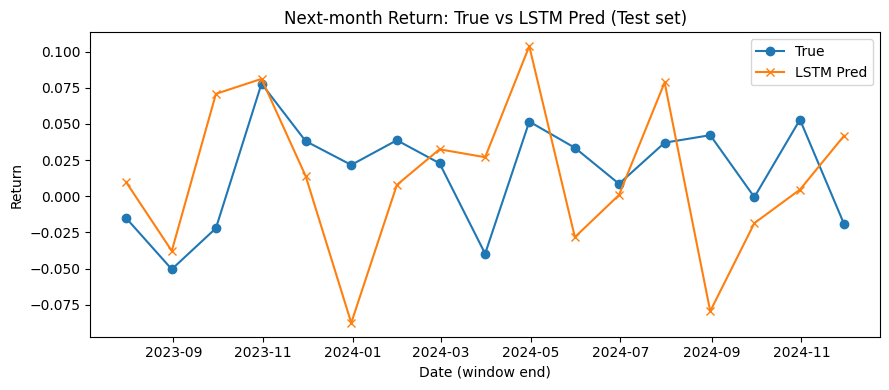

In [28]:
plt.figure(figsize=(9, 4))
plt.plot(test_dates, y_true, label="True", marker='o')
plt.plot(test_dates, y_pred, label="LSTM Pred", marker='x')
plt.title("Next-month Return: True vs LSTM Pred (Test set)")
plt.xlabel("Date (window end)")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()


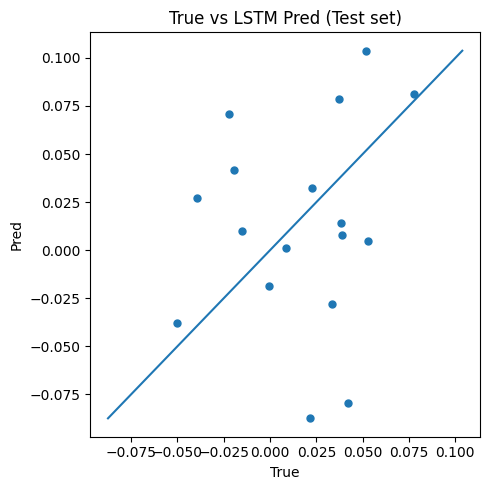

In [29]:
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=25)
xymin = min(float(y_true.min()), float(y_pred.min()))
xymax = max(float(y_true.max()), float(y_pred.max()))
plt.plot([xymin, xymax], [xymin, xymax]) 
plt.title("True vs LSTM Pred (Test set)")
plt.xlabel("True")
plt.ylabel("Pred")
plt.tight_layout()
plt.show()

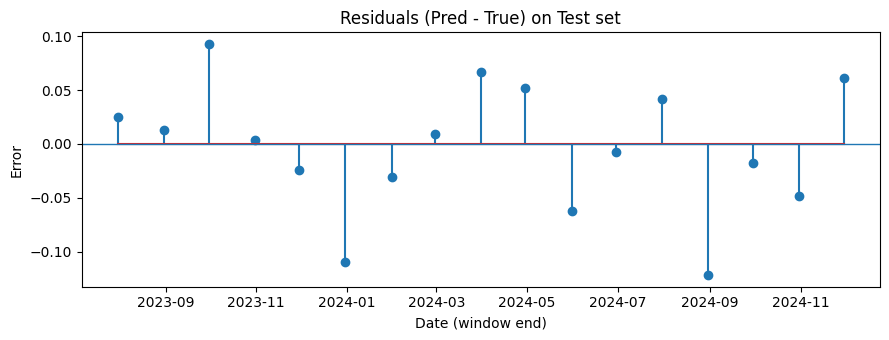

In [30]:
residuals = y_pred - y_true
plt.figure(figsize=(9, 3.5))
plt.stem(test_dates, residuals)
plt.axhline(0, linewidth=1)
plt.title("Residuals (Pred - True) on Test set")
plt.xlabel("Date (window end)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

In [31]:
np.mean((y_pred > 0) == (y_true > 0))

np.float64(0.5882352941176471)

In [32]:
y_pred_prev = df.loc[test_dates, "Return_prev_month"].to_numpy()

In [33]:
target_len = min(len(test_dates), len(y_true), len(y_pred), len(y_pred_prev), len(y_pred_lr))

def tail(x, n):
    return np.asarray(x)[-n:]

dates_aligned   = tail(test_dates, target_len)
true_aligned    = tail(y_true, target_len)
lstm_aligned    = tail(y_pred, target_len)
naive_aligned   = tail(y_pred_prev, target_len)
linear_aligned  = tail(y_pred_lr, target_len)

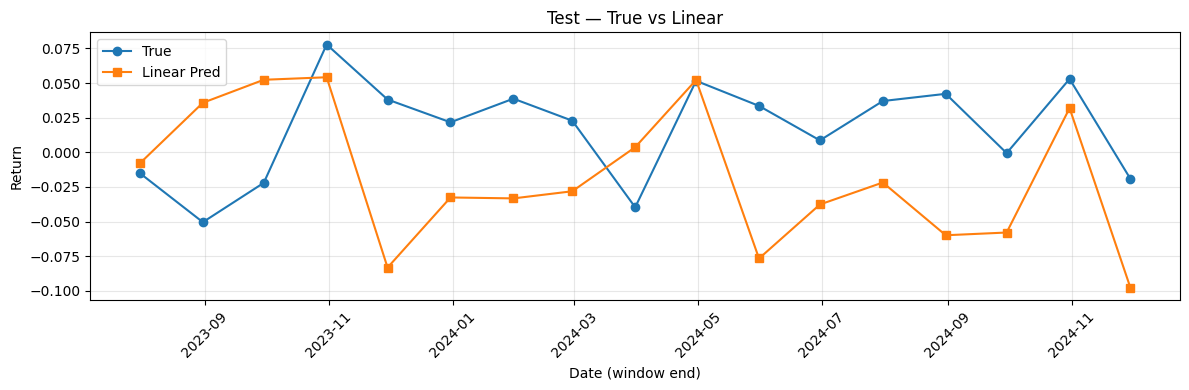

In [43]:
# True vs Linear
plt.figure(figsize=(12,4))
plt.plot(dates_aligned, true_aligned,   label="True",   marker='o')
plt.plot(dates_aligned, linear_aligned, label="Linear Pred", marker='s')
plt.title("Test — True vs Linear")
plt.xlabel("Date (window end)"); plt.ylabel("Return")
plt.legend(); plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

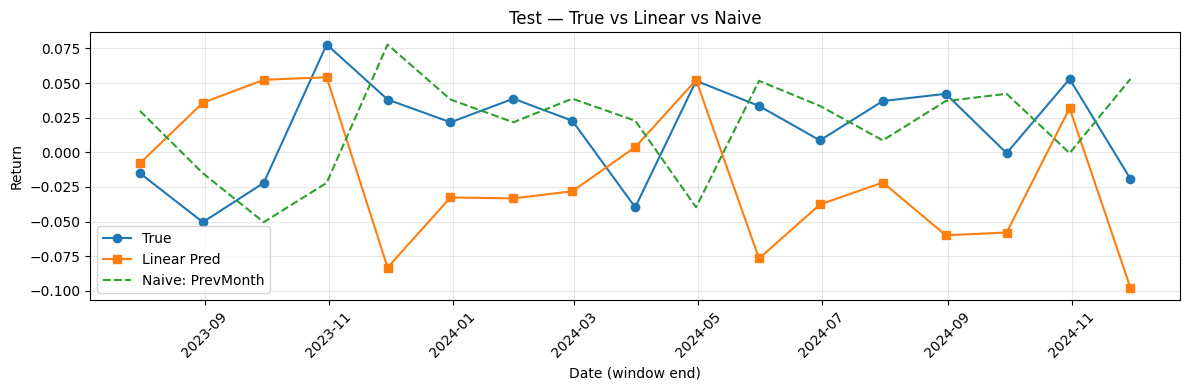

In [34]:
# True vs Linear vs Naive
plt.figure(figsize=(12,4))
plt.plot(dates_aligned, true_aligned,   label="True",   marker='o')
plt.plot(dates_aligned, linear_aligned, label="Linear Pred", marker='s')
plt.plot(dates_aligned, naive_aligned,  label="Naive: PrevMonth", linestyle="--")
plt.title("Test — True vs Linear vs Naive")
plt.xlabel("Date (window end)"); plt.ylabel("Return")
plt.legend(); plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

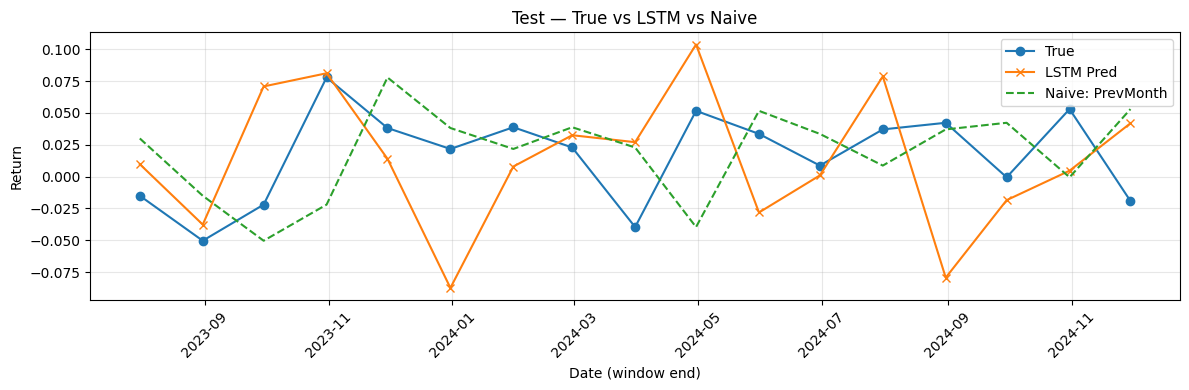

In [35]:
# True vs LSTM vs Naive
plt.figure(figsize=(12,4))
plt.plot(dates_aligned, true_aligned,  label="True", marker='o')
plt.plot(dates_aligned, lstm_aligned,  label="LSTM Pred", marker='x')
plt.plot(dates_aligned, naive_aligned, label="Naive: PrevMonth", linestyle="--")
plt.title("Test — True vs LSTM vs Naive")
plt.xlabel("Date (window end)"); plt.ylabel("Return")
plt.legend(); plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

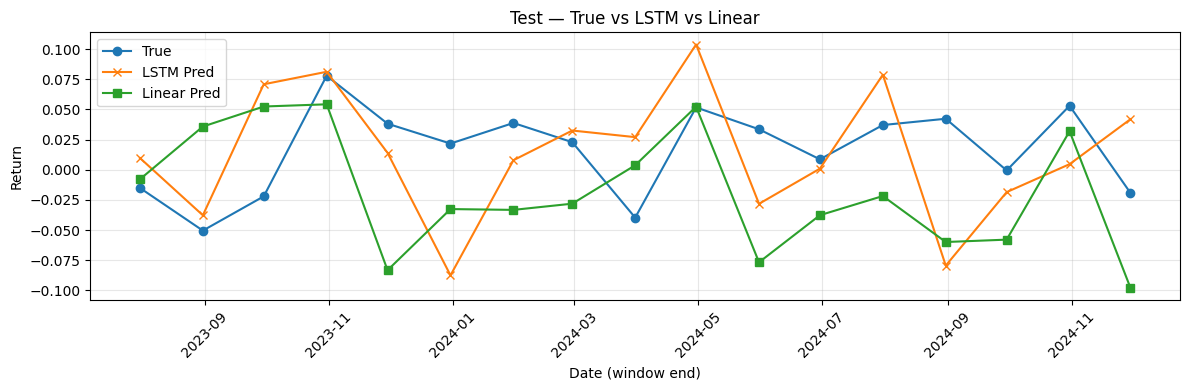

In [36]:
# True vs LSTM vs Linear
plt.figure(figsize=(12,4))
plt.plot(dates_aligned, true_aligned,   label="True", marker='o')
plt.plot(dates_aligned, lstm_aligned,   label="LSTM Pred", marker='x')
plt.plot(dates_aligned, linear_aligned, label="Linear Pred", marker='s')
plt.title("Test — True vs LSTM vs Linear")
plt.xlabel("Date (window end)"); plt.ylabel("Return")
plt.legend(); plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_rmse_mae_r2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_lin,  mae_lin,  r2_lin  = eval_rmse_mae_r2(true_aligned, linear_aligned)
rmse_lstm, mae_lstm, r2_lstm = eval_rmse_mae_r2(true_aligned, lstm_aligned)
rmse_nv,   mae_nv,   r2_nv   = eval_rmse_mae_r2(true_aligned, naive_aligned)

res_df = pd.DataFrame({
    "RMSE": [rmse_lin, rmse_lstm, rmse_nv],
    "MAE":  [mae_lin,  mae_lstm,  mae_nv],
    "R2":   [r2_lin,   r2_lstm,   r2_nv],
}, index=["Linear", "LSTM", "Naive"])

print("\nSummary:")
print(res_df.to_string(float_format=lambda x: f"{x:.6f}"))



Summary:
           RMSE      MAE        R2
Linear 0.068174 0.059326 -2.857098
LSTM   0.057871 0.046269 -1.779327
Naive  0.048752 0.040992 -0.972431


           RMSE      MAE        R2   DirAcc
Linear 0.068174 0.059326 -2.857098 0.352941
LSTM   0.057871 0.046269 -1.779327 0.588235
Naive  0.048752 0.040992 -0.972431 0.588235


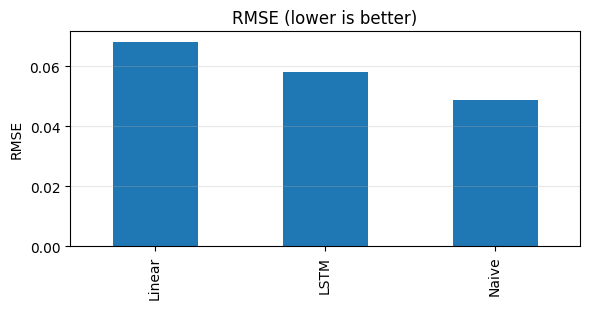

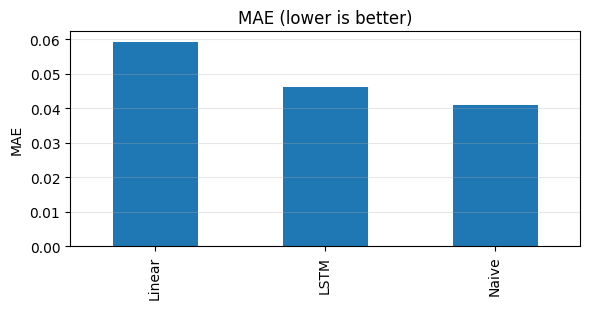

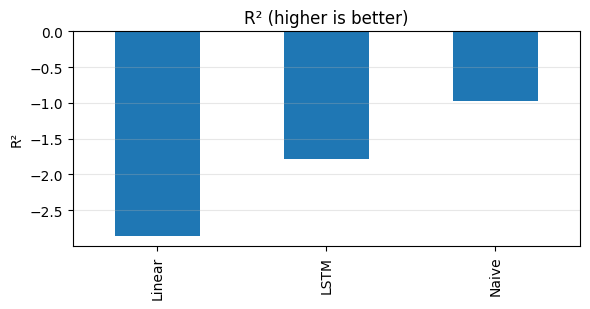

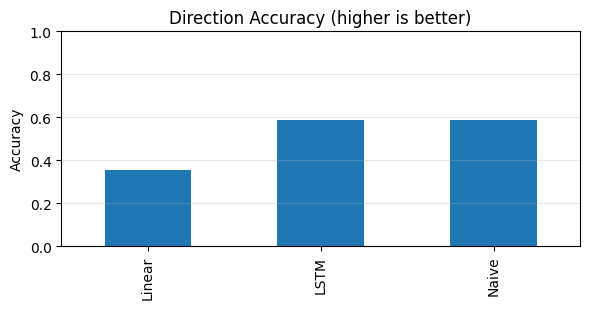

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_all(y_true, y_pred):
    y_true = np.ravel(y_true); y_pred = np.ravel(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return rmse, mae, r2, dir_acc

metrics = {}
for name, yhat in {
    "Linear": linear_aligned,
    "LSTM":   lstm_aligned,
    "Naive":  naive_aligned,
}.items():
    metrics[name] = eval_all(true_aligned, yhat)

res_df = pd.DataFrame(metrics, index=["RMSE", "MAE", "R2", "DirAcc"]).T
print(res_df.to_string(float_format=lambda x: f"{x:.6f}"))

plt.figure(figsize=(6,3.2))
res_df["RMSE"].plot(kind="bar")
plt.title("RMSE (lower is better)")
plt.ylabel("RMSE")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.2))
res_df["MAE"].plot(kind="bar")
plt.title("MAE (lower is better)")
plt.ylabel("MAE")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.2))
res_df["R2"].plot(kind="bar")
plt.title("R² (higher is better)")
plt.ylabel("R²")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.2))
res_df["DirAcc"].plot(kind="bar")
plt.title("Direction Accuracy (higher is better)")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()


In [39]:
def pairwise_improve(a, b):  # a 相对 b 的百分比提升（RMSE/MAE）
    return (b - a) / b * 100.0 if b != 0 else np.nan

pair_rows = []
# LSTM 相对 Linear
pair_rows.append([
    "LSTM over Linear",
    pairwise_improve(res_df.loc["LSTM", "RMSE"], res_df.loc["Linear", "RMSE"]),
    pairwise_improve(res_df.loc["LSTM", "MAE"],  res_df.loc["Linear", "MAE"]),
    res_df.loc["LSTM", "R2"] - res_df.loc["Linear", "R2"]
])
# Linear 相对 LSTM
pair_rows.append([
    "Linear over LSTM",
    pairwise_improve(res_df.loc["Linear", "RMSE"], res_df.loc["LSTM", "RMSE"]),
    pairwise_improve(res_df.loc["Linear", "MAE"],  res_df.loc["LSTM", "MAE"]),
    res_df.loc["Linear", "R2"] - res_df.loc["LSTM", "R2"]
])

pairwise = pd.DataFrame(pair_rows, columns=["Comparison", "RMSE_%Improve", "MAE_%Improve", "R2_Delta"]).set_index("Comparison")

print("\nPairwise comparison (higher is better):")
print(pairwise.to_string(float_format=lambda x: f"{x:.2f}"))



Pairwise comparison (higher is better):
                  RMSE_%Improve  MAE_%Improve  R2_Delta
Comparison                                             
LSTM over Linear          15.11         22.01      1.08
Linear over LSTM         -17.80        -28.22     -1.08


In [40]:
# —— 在已有 pair_rows 基础上继续追加 ——
# LSTM 相对 Naive
pair_rows.append([
    "LSTM over Naive",
    pairwise_improve(res_df.loc["LSTM", "RMSE"], res_df.loc["Naive", "RMSE"]),
    pairwise_improve(res_df.loc["LSTM", "MAE"],  res_df.loc["Naive", "MAE"]),
    res_df.loc["LSTM", "R2"] - res_df.loc["Naive", "R2"]
])
# Naive 相对 LSTM
pair_rows.append([
    "Naive over LSTM",
    pairwise_improve(res_df.loc["Naive", "RMSE"], res_df.loc["LSTM", "RMSE"]),
    pairwise_improve(res_df.loc["Naive", "MAE"],  res_df.loc["LSTM", "MAE"]),
    res_df.loc["Naive", "R2"] - res_df.loc["LSTM", "R2"]
])

# 重新生成/打印表
pairwise = pd.DataFrame(
    pair_rows,
    columns=["Comparison", "RMSE_%Improve", "MAE_%Improve", "R2_Delta"]
).set_index("Comparison")

print("\nPairwise comparison (higher is better):")
print(pairwise.to_string(float_format=lambda x: f"{x:.2f}"))



Pairwise comparison (higher is better):
                  RMSE_%Improve  MAE_%Improve  R2_Delta
Comparison                                             
LSTM over Linear          15.11         22.01      1.08
Linear over LSTM         -17.80        -28.22     -1.08
LSTM over Naive          -18.70        -12.87     -0.81
Naive over LSTM           15.76         11.41      0.81
